# O2O优惠券线下使用情况

https://blog.csdn.net/BiLiBa123/article/details/128020313?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522168272786316800184144333%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=168272786316800184144333&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-128020313-null-null.142^v86^control,239^v2^insert_chatgpt&utm_term=%E4%BC%98%E6%83%A0%E5%88%B8%E4%BD%BF%E7%94%A8%E6%83%85%E5%86%B5%E5%88%86%E6%9E%90&spm=1018.2226.3001.4187  

https://www.bilibili.com/video/BV1K24y1G7pJ?p=42

数据清洗工具：jupyter notebook

数据分析工具：Python

可视化图表工具：Pyecharts

分析类型：描述性分析，诊断分析

分析方法：漏斗分析，RFM用户价值分析，AARRR分析，假设检验分析。

## 一. 数据清洗

        1.1 数据集来源

数据来源：https://tianchi.aliyun.com/competition/entrance/231593/information

        1.2 数据说明
数据说明：用户在2016年1月1日至2016年6月30日之间真实线下消费行为数据

分析工具：Python

Table 1: 用户线下消费和优惠券领取行为

| Field | Description |  
| :--- | :--- |
| User_id | 用户ID |  
| Merchant_id | 商户ID|  
|Coupon_id | 优惠券ID：null表示无优惠券消费，此时Discount_rate和Date_received字段无意义 |
| Discount_rate | 优惠率：x \in [0,1]代表折扣率；x:y表示满x减y。单位是元 |
| Distanceuser | 经常活动的地点离该merchant的最近门店距离是x*500米（如果是连锁店，则取最近的一家门店），x\in[0,10]；<br>null表示无此信息，0表示低于500米，10表示大于5公里；|
| Date_received | 领取优惠券日期 |
| Date | 消费日期：<br>如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本；<br>如果Date!=null & Coupon_id = null，则表示普通消费日期；<br>如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本；

        1.3 数据导入

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [124]:
offline = pd.read_csv(r'C:\Users\wdl\Data-analysis\五大实战项目\5.O2O优惠券\data\ccf_offline_stage1_train.csv', parse_dates=['Date_received', 'Date'])
offline.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20:00,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:01,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:01,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:01,0.0,2016-06-13,NaT


In [125]:
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   User_id        1048575 non-null  int64         
 1   Merchant_id    1048575 non-null  int64         
 2   Coupon_id      629824 non-null   float64       
 3   Discount_rate  629824 non-null   object        
 4   Distance       985589 non-null   float64       
 5   Date_received  629824 non-null   datetime64[ns]
 6   Date           463717 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 56.0+ MB


        1.4 查看缺失值

In [126]:
offline.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        418751
Discount_rate    418751
Distance          62986
Date_received    418751
Date             584858
dtype: int64

            1.4.1 验证缺失值是否相等

In [127]:
nan1 = offline.Coupon_id.isna()
nan2 = offline.Discount_rate.isna()
nan3 = offline.Date_received.isna()

In [128]:
np.all(nan1 == nan2)

True

In [129]:
np.all(nan1 == nan3)

True

In [130]:
offline['Distance'].fillna(11, inplace=True)

        1.5 数据处理​编辑

            1.5.1 计算折扣率

In [131]:
def discount_rate_convert(s):
    if ':' in str(s):
        split = str(s).split(':')
        discount_rate = (int(split[0]) - int(split[1])) / int(split[0])
        return round(discount_rate, 2)
    elif s == np.NaN:
        return s
    else:
        return float(s)

In [132]:
offline['Discount_rate'] = offline.Discount_rate.map(discount_rate_convert)
offline.Discount_rate

0           NaN
1          0.87
2          0.95
3          0.95
4          0.95
           ... 
1048570    0.83
1048571    0.83
1048572     NaN
1048573     NaN
1048574     NaN
Name: Discount_rate, Length: 1048575, dtype: float64

## 二. 分析

        2.1 优惠券使用情况：
<br>Date == null & Coupon_id != null，有券未消费（cpon_no_consume）
<br>Date != null & Coupon_id == null，无券消费（no_cpon_consume）；
<br>Date != null & Coupon_id != null，有券消费（cpon_consume）；
<br>Date == null & Coupon_id == null，无券未消费（no_cpon_no_consume）；

In [133]:
cpon_no_consume = offline[(offline['Date'].isna() & offline['Coupon_id'].notna())]
no_cpon_consume = offline[(offline['Date'].notna() & offline['Coupon_id'].isna())]
cpon_consume = offline[(offline['Date'].notna() & offline['Coupon_id'].notna())]
no_cpon_no_consume = offline[(offline['Date'].isna() & offline['Coupon_id'].isna())]

In [134]:
print('有券未消费：', len(cpon_no_consume))
print('无券消费：', len(no_cpon_consume))
print('有券且消费：', len(cpon_consume))
print('无券未消费：', len(no_cpon_no_consume))

有券未消费： 584858
无券消费： 418751
有券且消费： 44966
无券未消费： 0


            2.1.1 优惠券使用情况分析可视化
        

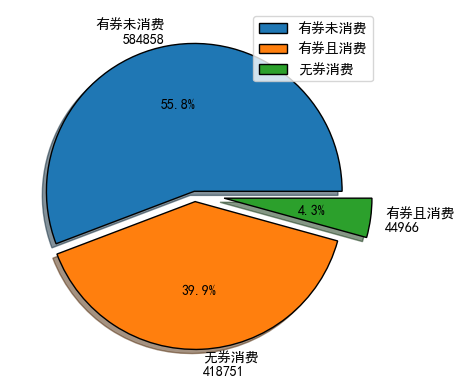

In [135]:
plt.pie([len(cpon_no_consume), len(no_cpon_consume), len(cpon_consume), ], 
        labels=['有券未消费\n{}'.format(len(cpon_no_consume)), 
                '无券消费\n{}'.format(len(no_cpon_consume)), 
                '有券且消费\n{}'.format(len(cpon_consume)),], 
        autopct='%1.1f%%',
        shadow=True,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        explode=[0.02, 0.05, 0.2],
        )
plt.legend(labels=['有券未消费', '有券且消费', '无券消费'], loc='best')
plt.show()

            2.1.2 有券，距离和优惠折扣力度

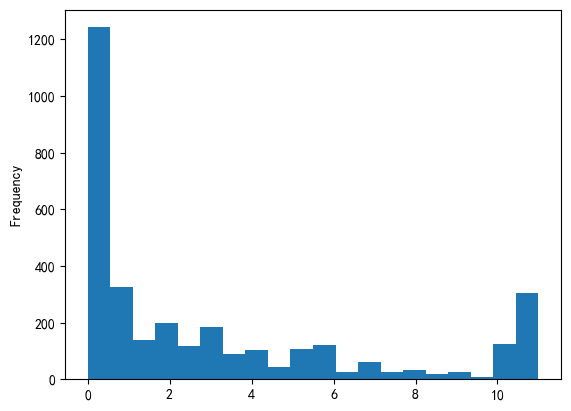

In [149]:
Merchant_distance = cpon_consume.groupby('Merchant_id').Distance.mean()
Merchant_distance.value_counts()
Merchant_distance.plot(kind='hist', bins=20)
plt.show()

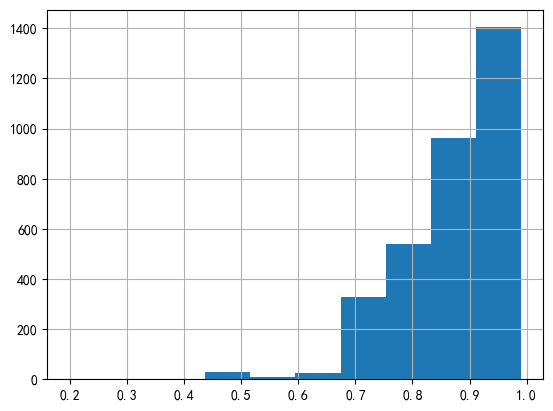

In [147]:
Merchant_distance_rate = cpon_consume.groupby('Merchant_id').Discount_rate.mean()
Merchant_distance_rate.sort_values()
Merchant_distance_rate.hist(bins=10)
plt.show()

## 三. 总体情况统计分析

        3.1 数据总体情况 

        3.2 优惠券每月核销情况统计

        3.3 每月新增用户数

## 四. 用户分析
        4.1 获客：每日新增用户情况

        4.2 转化及流失情况

        4.3 用户行为转化漏斗计算

        4.4 用户留存情况

        4.5 用户价值分析  
        
            4.5.1 先查询用户最近的消费时间间隔及消费频次

            4.5.2 分别查询R,F的最大值，最小值以及各值数量分布情况

            4.5.3 根据R,F值最大值和最小值的区间设计本次的打分标准，计算R,F的值

            4.5.4 查询R,F值的平均值

            4.5.5 根据平均值和用户分类规则表对用户分类

            4.5.6 查询各分层用户数量

## 五. 商户分析

        5.1 每月有消费商户统计

        5.2 一周内每天有消费的商户数量

        5.3 商户整体核销率，核销率在0.25以下的商户占比

        5.4 商户分层

## 六. 优惠券分析

        6.1 优惠券每日领取，每日核销情况

        6.2 优惠券平均核销时间

        6.3 不同距离下优惠券的领取量及核销率

## 七.  相关分析
        7.1 门店距离与优惠券核销率的相关性

        7.2 优惠券折扣与核销率的相关性

## 八. Tableau可视化图表

## 九. 数据分析